### OCR Demo

In [1]:
import os
import cv2
from glob import glob
from natsort import natsorted
from MonlamOCR.Inference import OCRPipeline
from MonlamOCR.Config import init_monlam_line_model, init_monlam_layout_model, init_monla_ocr_model
from MonlamOCR.Utils import get_file_name, read_line_model_config, read_layout_model_config, show_image

kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
e:\Github\OCR-Deployment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "SampleData"
output_dir = os.path.join(data_path, "Output")

img_ext = "jpg"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

print(f"Images: {len(image_paths)}")

Images: 2


(638, 3500, 3)


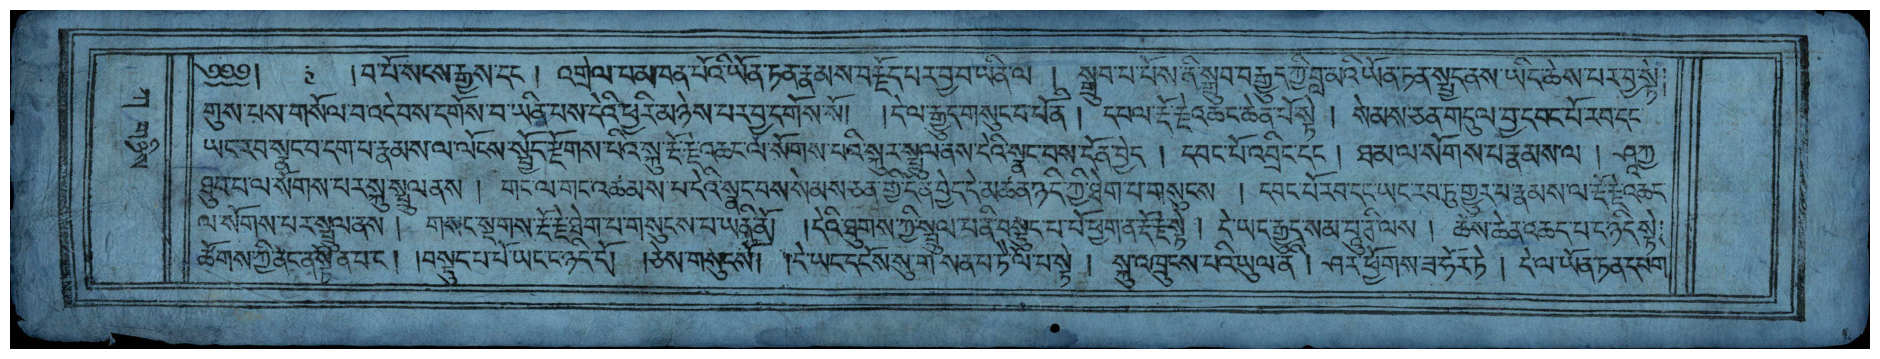

In [3]:
idx = 1
image_name = get_file_name(image_paths[idx])
img = cv2.imread(image_paths[idx])
print(img.shape)
show_image(img)

#### OCR via Pipelines using a line or layout model

In [4]:
# get model configs from HuggingFace models
line_model_config_file = init_monlam_line_model()
layout_model_config_file = init_monlam_layout_model()

line_model_config = read_line_model_config(line_model_config_file)
layout_model_config = read_layout_model_config(layout_model_config_file)

ocr_model_config = init_monla_ocr_model("Woodblock")

assert (ocr_model_config is not None)

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 1336.51it/s]


e:\Github\OCR-Deployment\.venv\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Running OCR in Line Mode
@##/ba po sangs rgyas dang /'grel pa mkhan po'i yon tan rnams brjod par bya ba yin la/sgrub pa pos ni sgrub brgyad kyi bla ma'i yon tan sprad nas yid ches par bya ste/
gus pas gsol ba 'debs dgos pa yin pas de'i phyir mnyes par bya dgos so//de la rgyud gsung ba po ni/dpal rdo rje 'ching chen po ste/sems can gdul bya dbang po rab dang
yang rab snang ba dag pa rnams la longs spyod rdzogs pa'i sku rdo rje 'chang la sogs pa'i skur sprul nas de'i snang bas don byed/dbang po 'bring dang /tha ma la sogs pa rnams la/shAkya
thub pa la sogs par sku sprul nas/gang la gang 'tshams pa de'i snang bas sems can gyi don byed de mtshan nyid kyi theg pa gsungs/dbang po rab dang yang rab tu gyur pa rnams la rdo rje 'chang
la sogs par sprul nas/gsang sngags rdo rje theg pa gsungs pa yin no//de'i thugs kyi sprul pa ni bsdud pa po phyag na rdo rje ste/de yang rgyud sam pU Ti las/ches chen 'chad pa nge nyid ste/
tshogs kyi nang na sten pa nga //bsdad pa po yang nga nyid do//ces gsungso

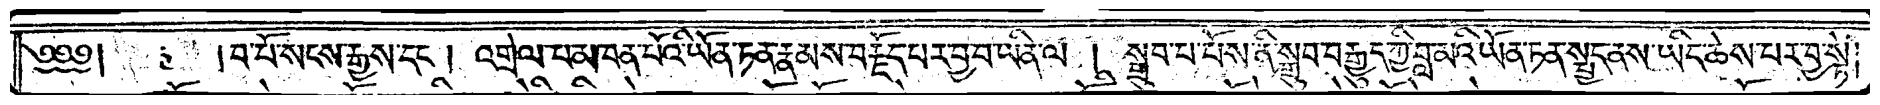

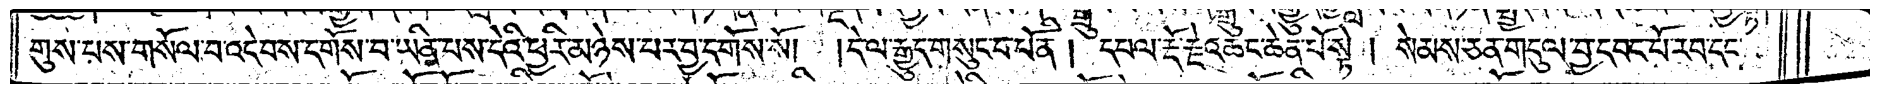

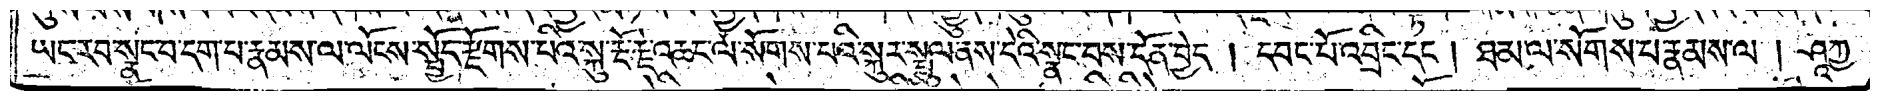

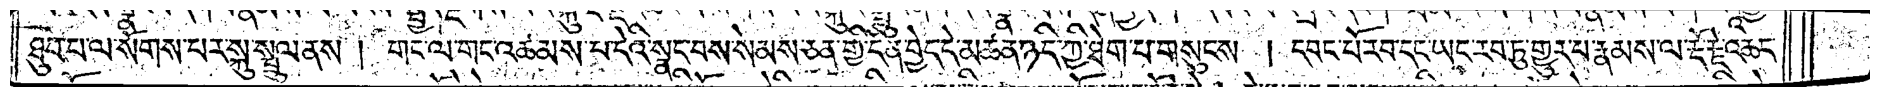

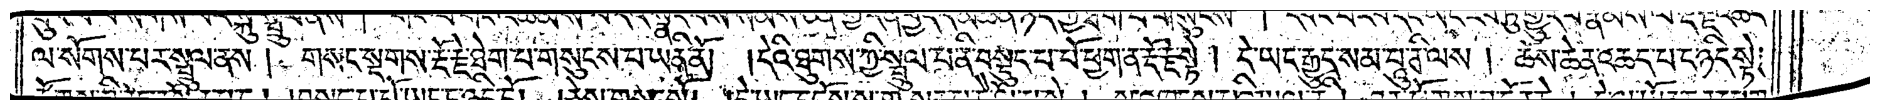

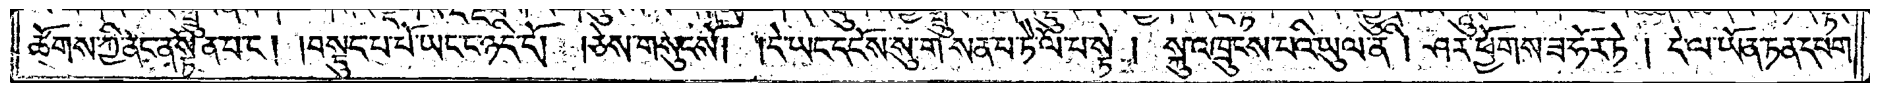

In [7]:
ocr_pipeline_line = OCRPipeline(ocr_model_config, line_model_config, output_dir)
text, line_data, line_images = ocr_pipeline_line.run_ocr(img, k_factor=1.5)

for line in text:
    print(line)

for line_img in line_images:
    show_image(line_img)

In [8]:
ocr_pipeline_layout = OCRPipeline(ocr_model_config, layout_model_config, output_dir)

text, line_data, line_images = ocr_pipeline_layout.run_ocr(img, k_factor=1.7)

for line in text:
    print(line)

Running OCR in Layout Mode
Layout Classes: ['background', 'image', 'line', 'margin', 'caption']
@##ba po sangs rgyas dang /'grel pa mkhan po'i yon tan rnams brjod par bya ba yin la/sgrub pa pos ni sgrub pa rgyud kyi bla ma'i yon tan spyad nas yid ches par bya ste/
gus pas gsol ba 'debs dgos pa yin pas de'i phyir mnyes par bya dgos so//de la rgyud gsung ba po ni/dpal rdo rje 'chong chen po ste/sems can gdul bya dbang po rab dang
yang rab snang ba dag pa rnams la longs spyod rdzogs pa'i sku rdo rje 'chang la sogs pa'i skur sprul nas de'i snang bas don byed/dbang po 'bring dang /tha ma la sogs pa rnams la/shAkya
thub pa la sogs par sku sprul nas/gang la gang 'tshams pa de'i snang bas sems can gyi don byed de mtshan nyid kyi theg pa gsungs/dbang po rab dang yang rab tu gyur pa rnams la rdo rje 'chang
la sogs par sprul nas/gsang sngags rdo rje theg pa gsungs pa yin no//de'i thugs kyi sprul pa ni bsdud pa po phyag na rdo rje ste/de yang rgyud sam pA Ti las/ches chen 'chad pa nga nyid ste/
ts

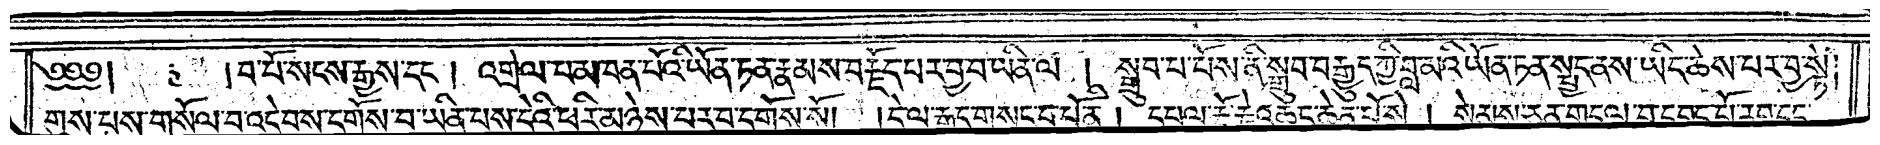

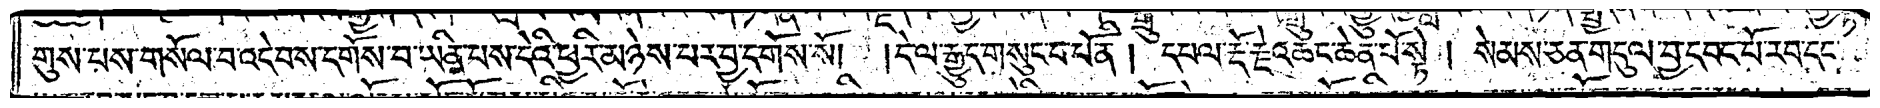

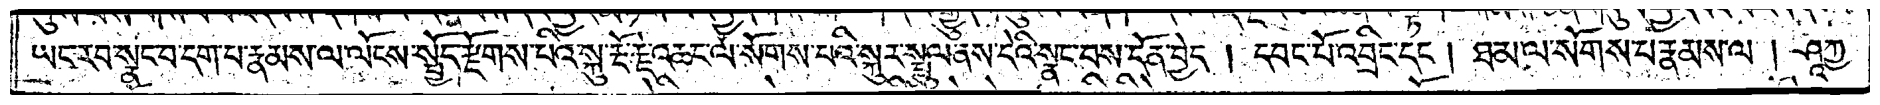

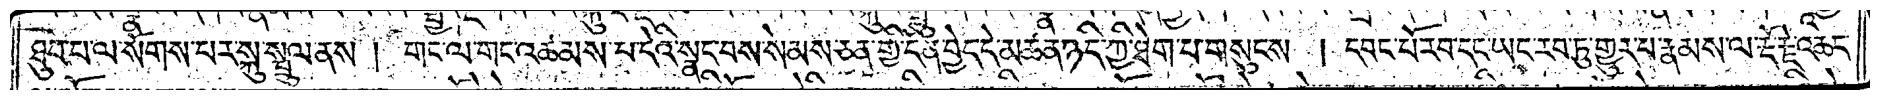

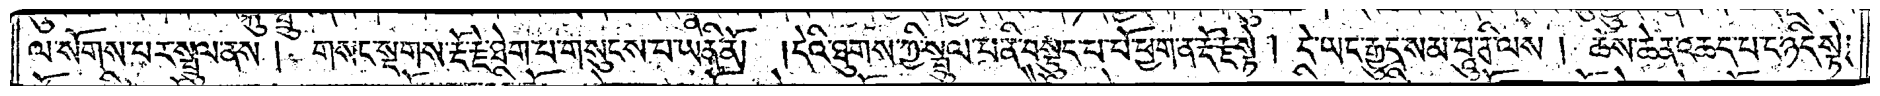

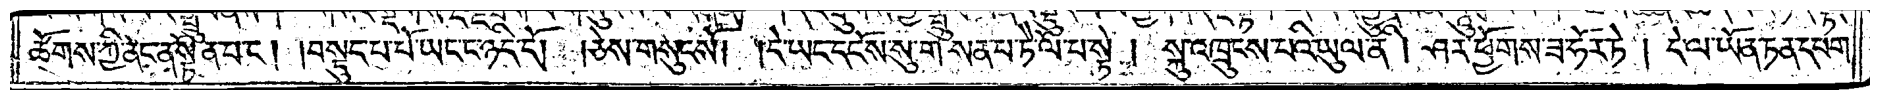

In [9]:
for line_img in line_images:
    show_image(line_img)

#### Export Data

In [10]:
from MonlamOCR.Exporter import JsonExporter, PageXMLExporter

In [11]:
# output page xml
xml_exporter = PageXMLExporter(output_dir)
xml_exporter.export_lines(img, image_name, line_data, text)

In [12]:
# output jsonl
json_exporter = JsonExporter(output_dir)
json_exporter.export_lines(img, image_name, line_data, text)